# Import Modules

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch 
import torch.nn as nn
from tqdm.auto import tqdm
import time
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer

# Import Dataset

In [152]:
df = pd.read_csv("movies_new.csv")
df = df.sort_values(by="startYear")
df.drop(columns=["originalTitle"], inplace=True)
df_recent = df[df["startYear"] >= 2015] 
print(f"Features: {df_recent.columns}")
print(f"Shape: {df_recent.shape}")

Features: Index(['tconst', 'titleType', 'primaryTitle', 'isAdult', 'startYear',
       'runtimeMinutes', 'genres', 'averageRating', 'numVotes', 'HitScore'],
      dtype='object')
Shape: (113868, 10)


In [153]:
df["genres"].value_counts()

genres
Documentary                  35908
Drama                        30969
Comedy                       14468
Comedy,Drama                  6299
Horror                        6177
                             ...  
Crime,Documentary,Fantasy        1
Crime,Sport,Thriller             1
History,Musical,Romance          1
Animation,Western                1
Adult,Romance,Sci-Fi             1
Name: count, Length: 1124, dtype: int64

In [142]:
genre = "Comedy"
# df = df[df['genres'].str.contains("Comedy", case=True)]
df = df[df["genres"] == genre]
print(f"{df.shape}")

(14468, 10)


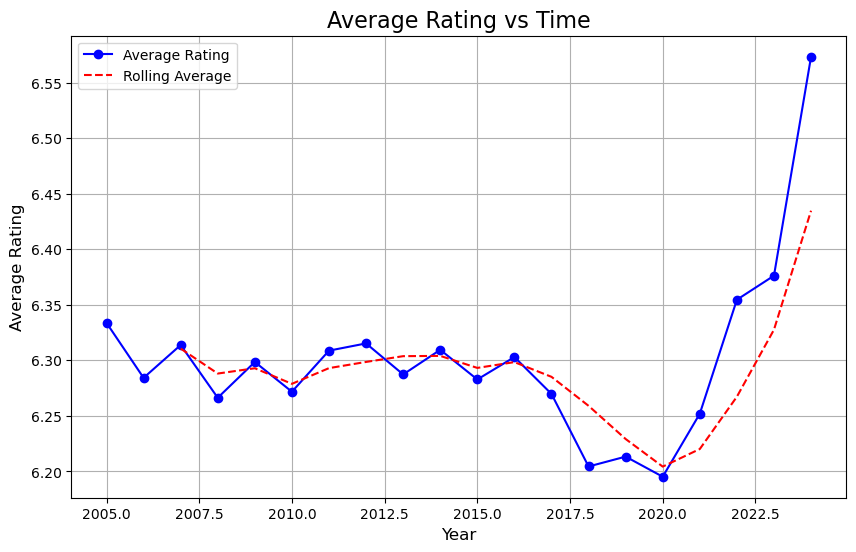

In [148]:
df_genre_grouped = df.groupby('startYear').agg({'averageRating': 'mean'}).reset_index()
plt.figure(figsize=(10, 6))
plt.plot(df_genre_grouped['startYear'], df_genre_grouped['averageRating'], marker='o', linestyle='-', color='b', label='Average Rating')
df_genre_grouped['rolling_avg'] = df_genre_grouped['averageRating'].rolling(window=3).mean()  # Adjust window as needed
plt.plot(df_genre_grouped['startYear'], df_genre_grouped['rolling_avg'], color='r', linestyle='--', label='Rolling Average')

plt.title(f'Average Rating vs Time', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


In [150]:
df_genre_grouped.shape

(20, 3)

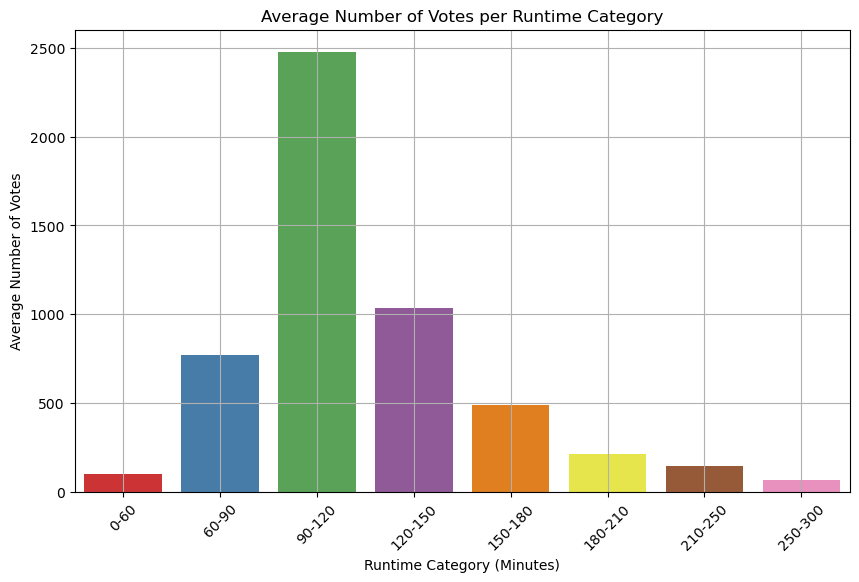

In [45]:

df['runtimeMinutes'] = pd.to_numeric(df['runtimeMinutes'], errors='coerce')


# Define bins for runtimes
bins = [0, 60, 90, 120, 150, 180, 210, 250, 300]
bin_labels = ['0-60', '60-90', '90-120', '120-150', '150-180', '180-210', '210-250', '250-300']

# Add a column for runtime categories
df['runtime_category'] = pd.cut(df['runtimeMinutes'], bins=bins, labels=bin_labels)

# Group by runtime categories and calculate the mean number of votes in each category
runtime_vote_group = df.groupby('runtime_category', observed=False)['numVotes'].mean().reset_index()

# Plot the result
plt.figure(figsize=(10, 6))
sns.barplot(data=runtime_vote_group, x='runtime_category', y='numVotes', palette='Set1', hue=bin_labels)  # Set hue=None to silence warning
plt.title('Average Number of Votes per Runtime Category')
plt.xlabel('Runtime Category (Minutes)')
plt.ylabel('Average Number of Votes')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


## Data Preprocessing 

In [47]:
df["runtimeMinutes"] = pd.to_numeric(df["runtimeMinutes"], errors="coerce")

#### Feature Engineering

In [154]:
# Convert to list
df['genres'] = df['genres'].replace('\\N', 'Unknown')
df['genres_list'] = df['genres'].apply(lambda x: x.split(','))
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(df['genres_list'])  # Fit & transform genres

genre_columns = mlb.classes_  # Get genre names as column names
df[genre_columns] = genre_encoded  # Add encoded genres to DataFrame

##select runTime
df["runtimeMinutes"] = pd.to_numeric(df["runtimeMinutes"], errors="coerce")
mean_runtime = df["runtimeMinutes"].mean()
df["runtimeMinutes"] = df["runtimeMinutes"].fillna(mean_runtime)
df = df[(df['runtimeMinutes'] >= 60) & (df['runtimeMinutes'] <= 250)]

##check for missing values
print(f"{df['averageRating'].isna().sum()}")
print(f"{df['numVotes'].isna().sum() }")

0
0


In [52]:
df.shape

(13681, 11)

### Relationship of averageRating, HitScore and total votes

In [ ]:
# Create scatter plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Scatter plot: HitScore vs averageRating
sns.scatterplot(x=df['averageRating'], y=df['HitScore'], ax=axes[0], color='b')
axes[0].set_title('HitScore vs. Average Rating')
axes[0].grid(True)

# Scatter plot: HitScore vs numVotes_log
sns.scatterplot(x=df['numVotes_log'], y=df['HitScore'], ax=axes[1], color='r')
axes[1].set_title('HitScore vs. NumVotes (log)')
axes[1].grid(True)  

# Scatter plot: averageRating vs numVotes_log
sns.scatterplot(x=df['averageRating'], y=df['numVotes_log'], ax=axes[2], color='g')
axes[2].set_title('Average Rating vs. NumVotes (log)')
axes[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

# Correlation matrix
corr_matrix = df[['averageRating', 'numVotes_log', 'HitScore']].corr()
corr_matrix


### Unique Genres

In [53]:
unique_genres = df['genres'].str.split(',').explode().str.strip().unique()
print(unique_genres)

['Comedy']


## Format For Vanilla MLP

### Features and Target

In [156]:
df['isAdult'] = df['isAdult'].astype(int)  
df['numVotes_log'] = np.log1p(df['numVotes'])


# **Define numerical & categorical features**
num_features = ['averageRating', 'numVotes_log']
cat_features = list(genre_columns)  # One-hot encoded genres

# Define features and target
# X = df[num_features].to_numpy()
X = df[num_features + cat_features].to_numpy()
y = df['HitScore'].to_numpy().reshape(-1,1)

# ## Get a subset of the dataset for faster training
X = X[:1000,:]
y = y[:1000,:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# print(f"{X_train.shape[0] + X_test.shape[0] == df.shape[0]}")
print(f"{X_train.shape[0] + X_test.shape[0] == df.iloc[:1000,:].shape[0]}")

True


### Normalize the dataset

In [158]:
# scalerX = StandardScaler()
# X_train_scaled = scalerX.fit_transform(X_train)  # Fit on training set
# X_test_scaled = scalerX.transform(X_test)

# **Apply StandardScaler ONLY on training set**
scalerX = StandardScaler()
X_train[:, :len(num_features)] = scalerX.fit_transform(X_train[:, :len(num_features)])  
X_test[:, :len(num_features)] = scalerX.transform(X_test[:, :len(num_features)])


scalerY = StandardScaler()
y_train_scaled = scalerY.fit_transform(y_train)  
y_test_scaled = scalerY.transform(y_test) 

### Convert to Tensors

In [159]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)


# Check shapes
print(X_train.shape, y_train_scaled.shape)
print(X_test.shape, y_test_scaled.shape)

(800, 29) (800, 1)
(200, 29) (200, 1)


### Dataloaders

In [160]:
import os
# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 16  

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=os.cpu_count(), shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=os.cpu_count(), shuffle=False)

print(f"Dataloaders:\nTrain dataloader: {train_dataloader}\nTest dataloader: {test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {train_dataloader.batch_size}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {test_dataloader.batch_size}")
print(f"=============================================================================="*100)

Dataloaders:
Train dataloader: <torch.utils.data.dataloader.DataLoader object at 0x79183aff4380>
Test dataloader: <torch.utils.data.dataloader.DataLoader object at 0x79183aff6e40>
Length of train dataloader: 50 batches of 16
Length of test dataloader: 13 batches of 16


## Format for Sequential/Time Series

### Convert the data into a sequential type

In [119]:
ratings = df["averageRating"].values
def create_sequences(X, y, time_step=3):
    Xs, ys = [], []
    for i in range(len(X) - time_step):
        Xs.append(X[i:i+time_step]) 
        ys.append(y[i+time_step])    # Target is the next year
    return np.array(Xs), np.array(ys)

X1, y1 = create_sequences(ratings, ratings)
X1 = X1.reshape(X1.shape[0], X1.shape[1], 1)
y1 = y1.reshape(-1, 1)

In [120]:
from sklearn.model_selection import train_test_split

# Assuming X and y are already reshaped
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, shuffle=False)


In [121]:
from sklearn.preprocessing import StandardScaler

scalerX = StandardScaler()
scalerY = StandardScaler()

X1_train_scaled = scalerX.fit_transform(X1_train.reshape(-1, X1_train.shape[1]))
X1_train_scaled  = X1_train_scaled.reshape(X1_train_scaled.shape[0], X1_train.shape[1], 1)
X1_test_scaled = scalerX.transform(X1_test.reshape(-1, X1_test.shape[1]))
X1_test_scaled = X1_test_scaled.reshape(X1_test_scaled.shape[0], X1_test.shape[1], 1)

y1_train_scaled = scalerY.fit_transform(y1_train)
y1_test_scaled = scalerY.transform(y1_test)

print(f"X_train_scaled shape: {X1_train_scaled.shape}")
print(f"y_train_scaled shape: {y1_train_scaled.shape}")  
print(f"X_test_scaled shape: {X1_test_scaled.shape}")
print(f"y_test_scaled shape: {y1_test_scaled.shape}")

X_train_scaled shape: (10942, 3, 1)
y_train_scaled shape: (10942, 1)
X_test_scaled shape: (2736, 3, 1)
y_test_scaled shape: (2736, 1)


### Convert to Tensors

In [122]:
# Convert to PyTorch tensors
X1_train_tensor = torch.tensor(X1_train_scaled, dtype=torch.float32)
X1_test_tensor = torch.tensor(X1_test_scaled, dtype=torch.float32)

y1_train_tensor = torch.tensor(y1_train_scaled, dtype=torch.float32)
y1_test_tensor = torch.tensor(y1_test_scaled, dtype=torch.float32)


# Check shapes
print(X1_train_tensor.shape, y1_train_tensor.shape)
print(X1_test_tensor.shape, y1_test_tensor.shape)

torch.Size([10942, 3, 1]) torch.Size([10942, 1])
torch.Size([2736, 3, 1]) torch.Size([2736, 1])


### Use Dataloaders from PyTorch

In [123]:
import os
# Create TensorDatasets
train1_dataset = TensorDataset(X1_train_tensor, y1_train_tensor)
test1_dataset = TensorDataset(X1_test_tensor, y1_test_tensor)

# Create DataLoaders
batch_size = 64 

train1_dataloader = DataLoader(train1_dataset, batch_size=batch_size, num_workers=os.cpu_count(), shuffle=True)
test1_dataloader = DataLoader(test1_dataset, batch_size=batch_size, num_workers=os.cpu_count(), shuffle=False)

print(f"Dataloaders:\nTrain dataloader: {train1_dataloader}\nTest dataloader: {test1_dataloader}")
print(f"Length of train dataloader: {len(train1_dataloader)} batches of {train1_dataloader.batch_size}")
print(f"Length of test dataloader: {len(test1_dataloader)} batches of {test1_dataloader.batch_size}")
print(f"=============================================================================="*100)


for batch, (X, y) in enumerate(train1_dataloader):
    print(f"Batch: {batch}")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    break

Dataloaders:
Train dataloader: <torch.utils.data.dataloader.DataLoader object at 0x79185c3dd430>
Test dataloader: <torch.utils.data.dataloader.DataLoader object at 0x79185cd36420>
Length of train dataloader: 171 batches of 64
Length of test dataloader: 43 batches of 64
Batch: 0
X shape: torch.Size([64, 3, 1])
y shape: torch.Size([64, 1])


# Optimizer

In [161]:
#Adan: Adaptive Nesterov Momentum Algorithm

import math
from typing import List
from torch import Tensor

class MultiTensorApply(object):
    available = False
    warned = False

    def __init__(self, chunk_size):
        try:
            MultiTensorApply.available = True
            self.chunk_size = chunk_size
        except ImportError as err:
            MultiTensorApply.available = False
            MultiTensorApply.import_err = err

    def __call__(self, op, noop_flag_buffer, tensor_lists, *args):
        return op(self.chunk_size, noop_flag_buffer, tensor_lists, *args)


class Adan(torch.optim.Optimizer):
    """
    Implements a pytorch variant of Adan
    Adan was proposed in
    Adan: Adaptive Nesterov Momentum Algorithm for
        Faster Optimizing Deep Models[J].arXiv preprint arXiv:2208.06677, 2022.
    https://arxiv.org/abs/2208.06677
    Arguments:
        params (iterable): iterable of parameters to optimize or
            dicts defining parameter groups.
        lr (float, optional): learning rate. (default: 1e-3)
        betas (Tuple[float, float, flot], optional): coefficients used for
            first- and second-order moments. (default: (0.98, 0.92, 0.99))
        eps (float, optional): term added to the denominator to improve
            numerical stability. (default: 1e-8)
        weight_decay (float, optional): decoupled weight decay
            (L2 penalty) (default: 0)
        max_grad_norm (float, optional): value used to clip
            global grad norm (default: 0.0 no clip)
        no_prox (bool): how to perform the decoupled weight decay
            (default: False)
        foreach (bool): if True would use torch._foreach implementation.
            It's faster but uses slightly more memory. (default: True)
        fused (bool, optional): whether fused implementation is used.
            (default: False)
    """
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.98, 0.92, 0.99),
                 eps=1e-8,
                 weight_decay=0.0,
                 max_grad_norm=0.0,
                 no_prox=False,
                 foreach: bool = True,
                 fused: bool = False):
        if not 0.0 <= max_grad_norm:
            raise ValueError('Invalid Max grad norm: {}'.format(max_grad_norm))
        if not 0.0 <= lr:
            raise ValueError('Invalid learning rate: {}'.format(lr))
        if not 0.0 <= eps:
            raise ValueError('Invalid epsilon value: {}'.format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError('Invalid beta parameter at index 0: {}'.format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError('Invalid beta parameter at index 1: {}'.format(
                betas[1]))
        if not 0.0 <= betas[2] < 1.0:
            raise ValueError('Invalid beta parameter at index 2: {}'.format(
                betas[2]))
        if fused:
            _check_fused_available()

        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        max_grad_norm=max_grad_norm,
                        no_prox=no_prox,
                        foreach=foreach,
                        fused=fused)
        super().__init__(params, defaults)

    def __setstate__(self, state):
        super(Adan, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('no_prox', False)

    @torch.no_grad()
    def restart_opt(self):
        for group in self.param_groups:
            group['step'] = 0
            for p in group['params']:
                if p.requires_grad:
                    state = self.state[p]
                    # State initialization

                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p)
                    # Exponential moving average of gradient difference
                    state['exp_avg_diff'] = torch.zeros_like(p)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step."""

        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        if self.defaults['max_grad_norm'] > 0:
            device = self.param_groups[0]['params'][0].device
            global_grad_norm = torch.zeros(1, device=device)

            max_grad_norm = torch.tensor(self.defaults['max_grad_norm'],
                                         device=device)
            for group in self.param_groups:

                for p in group['params']:
                    if p.grad is not None:
                        grad = p.grad
                        global_grad_norm.add_(grad.pow(2).sum())

            global_grad_norm = torch.sqrt(global_grad_norm)

            clip_global_grad_norm = torch.clamp(
                max_grad_norm / (global_grad_norm + group['eps']),
                max=1.0).item()
        else:
            clip_global_grad_norm = 1.0

        for group in self.param_groups:
            params_with_grad = []
            grads = []
            exp_avgs = []
            exp_avg_sqs = []
            exp_avg_diffs = []
            neg_pre_grads = []

            beta1, beta2, beta3 = group['betas']
            # assume same step across group now to simplify things
            # per parameter step can be easily support
            # by making it tensor, or pass list into kernel
            if 'step' in group:
                group['step'] += 1
            else:
                group['step'] = 1

            bias_correction1 = 1.0 - beta1**group['step']
            bias_correction2 = 1.0 - beta2**group['step']
            bias_correction3 = 1.0 - beta3**group['step']

            for p in group['params']:
                if p.grad is None:
                    continue
                params_with_grad.append(p)
                grads.append(p.grad)

                state = self.state[p]
                if len(state) == 0:
                    state['exp_avg'] = torch.zeros_like(p)
                    state['exp_avg_sq'] = torch.zeros_like(p)
                    state['exp_avg_diff'] = torch.zeros_like(p)

                if 'neg_pre_grad' not in state or group['step'] == 1:
                    state['neg_pre_grad'] = p.grad.clone().mul_(
                        -clip_global_grad_norm)

                exp_avgs.append(state['exp_avg'])
                exp_avg_sqs.append(state['exp_avg_sq'])
                exp_avg_diffs.append(state['exp_avg_diff'])
                neg_pre_grads.append(state['neg_pre_grad'])

            if not params_with_grad:
                continue

            kwargs = dict(
                params=params_with_grad,
                grads=grads,
                exp_avgs=exp_avgs,
                exp_avg_sqs=exp_avg_sqs,
                exp_avg_diffs=exp_avg_diffs,
                neg_pre_grads=neg_pre_grads,
                beta1=beta1,
                beta2=beta2,
                beta3=beta3,
                bias_correction1=bias_correction1,
                bias_correction2=bias_correction2,
                bias_correction3_sqrt=math.sqrt(bias_correction3),
                lr=group['lr'],
                weight_decay=group['weight_decay'],
                eps=group['eps'],
                no_prox=group['no_prox'],
                clip_global_grad_norm=clip_global_grad_norm,
            )

            if group['foreach']:
                if group['fused']:
                    if torch.cuda.is_available():
                        _fused_adan_multi_tensor(**kwargs)
                    else:
                        raise ValueError('Fused Adan does not support CPU')
                else:
                    _multi_tensor_adan(**kwargs)
            elif group['fused']:
                if torch.cuda.is_available():
                    _fused_adan_single_tensor(**kwargs)
                else:
                    raise ValueError('Fused Adan does not support CPU')
            else:
                _single_tensor_adan(**kwargs)

        return loss


def _single_tensor_adan(
    params: List[Tensor],
    grads: List[Tensor],
    exp_avgs: List[Tensor],
    exp_avg_sqs: List[Tensor],
    exp_avg_diffs: List[Tensor],
    neg_pre_grads: List[Tensor],
    *,
    beta1: float,
    beta2: float,
    beta3: float,
    bias_correction1: float,
    bias_correction2: float,
    bias_correction3_sqrt: float,
    lr: float,
    weight_decay: float,
    eps: float,
    no_prox: bool,
    clip_global_grad_norm: Tensor,
):
    for i, param in enumerate(params):
        grad = grads[i]
        exp_avg = exp_avgs[i]
        exp_avg_sq = exp_avg_sqs[i]
        exp_avg_diff = exp_avg_diffs[i]
        neg_grad_or_diff = neg_pre_grads[i]

        grad.mul_(clip_global_grad_norm)

        # for memory saving, we use `neg_grad_or_diff`
        # to get some temp variable in a inplace way
        neg_grad_or_diff.add_(grad)

        exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)  # m_t
        exp_avg_diff.mul_(beta2).add_(neg_grad_or_diff,
                                      alpha=1 - beta2)  # diff_t

        neg_grad_or_diff.mul_(beta2).add_(grad)
        exp_avg_sq.mul_(beta3).addcmul_(neg_grad_or_diff,
                                        neg_grad_or_diff,
                                        value=1 - beta3)  # n_t

        denom = ((exp_avg_sq).sqrt() / bias_correction3_sqrt).add_(eps)
        step_size_diff = lr * beta2 / bias_correction2
        step_size = lr / bias_correction1

        if no_prox:
            param.mul_(1 - lr * weight_decay)
            param.addcdiv_(exp_avg, denom, value=-step_size)
            param.addcdiv_(exp_avg_diff, denom, value=-step_size_diff)
        else:
            param.addcdiv_(exp_avg, denom, value=-step_size)
            param.addcdiv_(exp_avg_diff, denom, value=-step_size_diff)
            param.div_(1 + lr * weight_decay)

        neg_grad_or_diff.zero_().add_(grad, alpha=-1.0)


def _multi_tensor_adan(
    params: List[Tensor],
    grads: List[Tensor],
    exp_avgs: List[Tensor],
    exp_avg_sqs: List[Tensor],
    exp_avg_diffs: List[Tensor],
    neg_pre_grads: List[Tensor],
    *,
    beta1: float,
    beta2: float,
    beta3: float,
    bias_correction1: float,
    bias_correction2: float,
    bias_correction3_sqrt: float,
    lr: float,
    weight_decay: float,
    eps: float,
    no_prox: bool,
    clip_global_grad_norm: Tensor,
):
    if len(params) == 0:
        return

    torch._foreach_mul_(grads, clip_global_grad_norm)

    # for memory saving, we use `neg_pre_grads`
    # to get some temp variable in a inplace way
    torch._foreach_add_(neg_pre_grads, grads)

    torch._foreach_mul_(exp_avgs, beta1)
    torch._foreach_add_(exp_avgs, grads, alpha=1 - beta1)  # m_t

    torch._foreach_mul_(exp_avg_diffs, beta2)
    torch._foreach_add_(exp_avg_diffs, neg_pre_grads,
                        alpha=1 - beta2)  # diff_t

    torch._foreach_mul_(neg_pre_grads, beta2)
    torch._foreach_add_(neg_pre_grads, grads)
    torch._foreach_mul_(exp_avg_sqs, beta3)
    torch._foreach_addcmul_(exp_avg_sqs,
                            neg_pre_grads,
                            neg_pre_grads,
                            value=1 - beta3)  # n_t

    denom = torch._foreach_sqrt(exp_avg_sqs)
    torch._foreach_div_(denom, bias_correction3_sqrt)
    torch._foreach_add_(denom, eps)

    step_size_diff = lr * beta2 / bias_correction2
    step_size = lr / bias_correction1

    if no_prox:
        torch._foreach_mul_(params, 1 - lr * weight_decay)
        torch._foreach_addcdiv_(params, exp_avgs, denom, value=-step_size)
        torch._foreach_addcdiv_(params,
                                exp_avg_diffs,
                                denom,
                                value=-step_size_diff)
    else:
        torch._foreach_addcdiv_(params, exp_avgs, denom, value=-step_size)
        torch._foreach_addcdiv_(params,
                                exp_avg_diffs,
                                denom,
                                value=-step_size_diff)
        torch._foreach_div_(params, 1 + lr * weight_decay)
    torch._foreach_zero_(neg_pre_grads)
    torch._foreach_add_(neg_pre_grads, grads, alpha=-1.0)


def _fused_adan_multi_tensor(
    params: List[Tensor],
    grads: List[Tensor],
    exp_avgs: List[Tensor],
    exp_avg_sqs: List[Tensor],
    exp_avg_diffs: List[Tensor],
    neg_pre_grads: List[Tensor],
    *,
    beta1: float,
    beta2: float,
    beta3: float,
    bias_correction1: float,
    bias_correction2: float,
    bias_correction3_sqrt: float,
    lr: float,
    weight_decay: float,
    eps: float,
    no_prox: bool,
    clip_global_grad_norm: Tensor,
):
    import fused_adan
    multi_tensor_applier = MultiTensorApply(2048 * 32)
    _dummy_overflow_buf = torch.cuda.IntTensor([0])
    multi_tensor_applier(
        fused_adan.adan_multi_tensor, _dummy_overflow_buf,
        [params, grads, exp_avgs, exp_avg_sqs, exp_avg_diffs, neg_pre_grads],
        beta1, beta2, beta3, bias_correction1, bias_correction2,
        bias_correction3_sqrt, lr, weight_decay, eps, no_prox,
        clip_global_grad_norm)
    torch._foreach_zero_(neg_pre_grads)
    torch._foreach_add_(neg_pre_grads, grads, alpha=-1.0)


def _fused_adan_single_tensor(
    params: List[Tensor],
    grads: List[Tensor],
    exp_avgs: List[Tensor],
    exp_avg_sqs: List[Tensor],
    exp_avg_diffs: List[Tensor],
    neg_pre_grads: List[Tensor],
    *,
    beta1: float,
    beta2: float,
    beta3: float,
    bias_correction1: float,
    bias_correction2: float,
    bias_correction3_sqrt: float,
    lr: float,
    weight_decay: float,
    eps: float,
    no_prox: bool,
    clip_global_grad_norm: Tensor,
):
    for i, param in enumerate(params):
        p_data_fp32 = param.data.float()
        out_p = param.data
        grad = grads[i]
        exp_avg = exp_avgs[i]
        exp_avg_sq = exp_avg_sqs[i]
        exp_avg_diff = exp_avg_diffs[i]
        neg_grad = neg_pre_grads[i]
        with torch.cuda.device(param.device):
            import fused_adan
            fused_adan.adan_single_tensor(
                p_data_fp32,
                out_p,
                grad,
                exp_avg,
                exp_avg_sq,
                exp_avg_diff,
                neg_grad,
                beta1,
                beta2,
                beta3,
                bias_correction1,
                bias_correction2,
                bias_correction3_sqrt,
                lr,
                weight_decay,
                eps,
                no_prox,
                clip_global_grad_norm,
            )
        neg_grad.zero_().add_(grad, alpha=-1.0)


def _check_fused_available():
    try:
        import fused_adan
    except ImportError as exc:
        if torch.cuda.is_available():
            # The module should be available but isn't. Try to
            # help the user in this case.
            raise ImportError((
                str(exc)
                + (
                    '\nThis could be caused by not having compiled '
                    'the CUDA extension during package installation. '
                    'Please try to re-install the package with '
                    'the environment flag `FORCE_CUDA=1` set.'
                )
            ))
        else:
            raise ImportError(
                str(exc) + '\nFused Adan does not support CPU.')

# Setup Device Agnostic Code

In [162]:
import os
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

if device == "cuda":
    import torch.backends.cudnn as cudnn
    cudnn.deterministic = True
    cudnn.benchmark = False
    !nvidia-smi
else:
    print(f"Number of cores: {os.cpu_count()}")

Device: cuda
Mon Mar 10 00:53:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2050        Off |   00000000:01:00.0  On |                  N/A |
| N/A   48C    P5              6W /   55W |     464MiB /   4096MiB |     16%      Default |
|                                         |                        |                  N/A |
+----------------------------------

In [163]:
device = "cpu"

# Creating the Models

## CNN-LSTM

In [90]:
from torch import dropout


cnn_params = [8, 16, "MaxPool"]
class CNN1D(nn.Module):
    def __init__(self, input):
        super(CNN1D, self).__init__()
        self.input = input
        self.conv_blocks = self.create_conv_blocks(cnn_params)
        
    def create_conv_blocks(self, architecture):
        layers = []
        input = self.input

        for x in architecture:
            if type(x) == int:
                output = x
                layers += [nn.Conv1d(input, output, 
                        kernel_size=2, stride=1, padding=0),
                        nn.BatchNorm1d(x),
                        nn.SiLU()]

                input = x  # Update input channels
            elif x == "MaxPool":
                layers += [nn.MaxPool1d(kernel_size=2, stride=1)]

        return nn.Sequential(*layers)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, features, time_steps) → (batch, channels, time_steps)
        x = self.conv_blocks(x)
        return x  # Output shape: (batch, channels, reduced_time_steps)

class MainModel(nn.Module):
    def __init__(self, input_size=2, hidden_size=200, num_layers=3, output_size=1):
        super(MainModel, self).__init__()
        self.num_layers = num_layers  
        self.hidden_size = hidden_size
        self.cnn = CNN1D(input_size)
        self.lstm = nn.LSTM(input_size=16, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 150),
            nn.SiLU(),
            nn.Dropout(0.3),
            nn.Linear(150, output_size)
        )

    def forward(self, x: torch.Tensor, h0=None, c0=None):
        x = self.cnn(x)
        x = x.permute(0, 2, 1)  # (batch, channels, time) → (batch, time, channels)
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.num_layers, x.size(0),self.hidden_size)
            c0 = torch.zeros(self.num_layers, x.size(0),self.hidden_size)
            # h0 = torch.randn(self.num_layers, x.size(0), self.hidden_size) * 0.02
            # c0 = torch.randn(self.num_layers, x.size(0), self.hidden_size) * 0.02
        x, _ = self.lstm(x, (h0, c0))
        x = x[:, -1, :]
        x = self.fc(x) 
        return x


torch.manual_seed(25)
# Instantiate Model
model69 = MainModel(input_size=X1_train_tensor.shape[2], hidden_size=12, num_layers=3, output_size=1).to(device)

print(f"{model69}")


# Count the total number of parameters
total_params = sum(p.numel() for p in model69.parameters())
print(f"Total number of parameters: {total_params}")


MainModel(
  (cnn): CNN1D(
    (conv_blocks): Sequential(
      (0): Conv1d(1, 8, kernel_size=(2,), stride=(1,))
      (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU()
      (3): Conv1d(8, 16, kernel_size=(2,), stride=(1,))
      (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): SiLU()
      (6): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (lstm): LSTM(16, 12, num_layers=3, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=12, out_features=150, bias=True)
    (1): SiLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=150, out_features=1, bias=True)
  )
)
Total number of parameters: 6381


## LSTM Only

In [199]:
class MyModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MyModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, output_size, spline_order=2, grid_size=4)
        )
    def forward(self, x: torch.Tensor, h0=None, c0=None):
        ##initialize hidden state
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.num_layers, x.size(0),self.hidden_size)
            c0 = torch.zeros(self.num_layers, x.size(0),self.hidden_size)
        x, _ = self.lstm(x, (h0, c0))
        x = x[:, -1, :]
        x = self.fc(x)
        return x
    
torch.manual_seed(25)
# Instantiate Model
model = MyModel(input_size=X1_train_tensor.shape[2], hidden_size=5, num_layers=1, output_size=1).to(device)

print(f"{model}")


# Count the total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

TypeError: Linear.__init__() got an unexpected keyword argument 'spline_order'

## Vanilla MLP

In [164]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size=1000, output_size=1):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.SiLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size),
            nn.SiLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, output_size)
        )
    
    def forward(self, x):
        return self.model(x)

## Kolgomorov Arnold Networks

In [194]:
import torch
import torch.nn.functional as F
import math

class KANLayer(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_range=[-1, 1],
    ):
        super(KANLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + self.spline_order, self.in_features, self.out_features) - 0.5
                ) * self.scale_noise / self.grid_size
            )
            noise = noise.permute(2, 1, 0)  # Ensure correct shape (out_features, in_features, grid_size + spline_order)
            self.spline_weight.data.copy_(self.scale_spline * noise)
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor): ### --> Cox De Boor Recursion
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.reshape(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output
        
        output = output.reshape(*original_shape[:-1], self.out_features)
        return output  ## --> spline(x) + SiLU(x)

In [181]:
class ClassicKAN(nn.Module):
  def __init__(self, in_features, out_features, hidden_units=100):
    super(ClassicKAN, self).__init__()
    self.KanLayerStack = nn.Sequential(
      KANLayer(in_features, hidden_units, spline_order=3, grid_size=5),
      nn.BatchNorm1d(hidden_units),
      KANLayer(hidden_units, out_features, spline_order=2, grid_size=2))
  

  def forward(self, x):
    return self.KanLayerStack(x)

model1 = ClassicKAN(in_features = X_train_tensor.shape[1], out_features=1)
print(f"{model1}")

ClassicKAN(
  (KanLayerStack): Sequential(
    (0): KANLayer(
      (base_activation): SiLU()
    )
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): KANLayer(
      (base_activation): SiLU()
    )
  )
)


In [165]:
device = "cpu"
dummy  = torch.randn(X_train_tensor.shape[0], X_train_tensor.shape[1])
model = MLP(input_size=X_train_tensor.shape[1], hidden_size=1000, output_size=1).to(device)
# print(model)
y_pred = model(dummy)

## Test on a Dummy Data

In [92]:
dummy = torch.randn(X1_train_tensor.shape[0], X1_train_tensor.shape[1], X1_train_tensor.shape[2])
# Test Forward Pass
# y = model(dummy)  # Testing with dummy training data
y = model69(X1_train_tensor)
print(f"{y.shape}")
print(f"{y}")

torch.Size([10938, 1])
tensor([[0.1117],
        [0.0718],
        [0.1129],
        ...,
        [0.0601],
        [0.0626],
        [0.0407]], grad_fn=<AddmmBackward0>)


## Define Train and Test functions for training

In [126]:
def train(data_loader:torch.utils.data.DataLoader,
               model:torch.nn.Module,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               calculate_accuracy,
               device: torch.device = device,
               loss_steps: int = 100,
               seed: int = 25):
  # Set seed for reproducibility
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

  #Training
  train_loss, train_acc = 0, 0
  #Put Data into training Mode
  model.train()
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    train_acc += calculate_accuracy(y_true=y,
                             y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss = train_loss / len(data_loader)
  train_acc = train_acc / len(data_loader)
  if epoch % loss_steps == 0:
    print(f"Training Loss: {train_loss:.5f} | Training R2: {train_acc:.4f}")
  return train_loss, train_acc

def test(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              calculate_accuracy,
              device: torch.device = device,
              loss_steps: int = 100,
              seed: int = 42):
  # Set seed for reproducibility
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

  #Testing
  test_loss, test_acc = 0, 0
  model.to(device)
  #Put Data into evaluation Mode
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X,y = X.to(device), y.to(device)
      test_pred = model(X)
      loss = loss_fn(test_pred, y)
      test_loss += loss.item()
      test_acc += calculate_accuracy(y_true=y, y_pred=test_pred)

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    if epoch % loss_steps == 0:
      print(f"Test Loss {test_loss:.5f} | Test R2 {test_acc:5f}")
    return test_loss, test_acc

## Setup parameters, objective function, and r2 metric

In [176]:
from sklearn.metrics import r2_score
def calculate_accuracy(y_true, y_pred):
    """
    Computes an accuracy-like metric for regression using R^2 Score.
    """
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()

    r2 = r2_score(y_true, y_pred)  # Best: 1, Worst: -∞
    return r2  # Treat as "accuracy" for regression

## Setup loss function
loss_fn = nn.MSELoss()

device = "cpu"
num_of_epochs = 50
num_loss_steps = 5
seed_number = 42
learning_rate = 0.001

# Train the Model

## Train CNN-LSTM

In [ ]:
np.random.seed(seed_number)
torch.manual_seed(seed_number)
torch.cuda.manual_seed_all(seed_number)

model = MainModel(input_size=X1_train_tensor.shape[2], 
                  hidden_size=10, num_layers=3, output_size=1).to(device)


optimizer= Adan(params=model.parameters(), 
                lr=0.001, 
                betas=(0.94, 0.91, 0.999), 
                weight_decay=1e-2)

# optimizer = torch.optim.Adam(params=model.parameters(), 
#                               lr=0.001, 
#                               betas=(0.9,0.99),
#                               eps=1e-6,
#                               weight_decay=0.01)

results = {
    "train_loss": [],
    "train_accu": [],
    "test_loss": [],
    "test_accu": []
}

start_time = time.perf_counter()
for epoch in tqdm(range(0, num_of_epochs)):
  if epoch % num_loss_steps == 0:
    print(f"Epoch: {epoch} \n =====================================================================")

  train_loss, train_accu = train(data_loader = train1_dataloader,
                                  model = model,
                                  loss_fn = loss_fn,
                                  optimizer = optimizer,
                                  calculate_accuracy = calculate_accuracy,
                                  device = device,
                                  loss_steps = num_loss_steps,
                                  seed = seed_number);

  test_loss, test_accu = test(data_loader = test1_dataloader,
                              model = model,
                              loss_fn = loss_fn,
                              calculate_accuracy = calculate_accuracy,
                              device = device,
                              loss_steps = num_loss_steps,
                              seed=seed_number);


  results["train_loss"].append(train_loss)
  results["train_accu"].append(train_accu)
  results["test_loss"].append(test_loss)
  results["test_accu"].append(test_accu)
  
end_time = time.perf_counter()
total_time = end_time- start_time
print(f"Total Runtime: {total_time / 60: .2f}")

## Train LSTM

In [197]:
seed_number = 42
np.random.seed(seed_number)
torch.manual_seed(seed_number)
torch.cuda.manual_seed_all(seed_number)


model3 = MyModel(input_size=X1_train_tensor.shape[2],
                 hidden_size=5, num_layers=3, output_size=1).to(device)

optimizer= Adan(params=model3.parameters(), 
                lr=0.001, 
                betas=(0.94, 0.92, 0.95), 
                weight_decay=1e-2)

# optimizer = torch.optim.Adam(params=model3.parameters(),
#                              lr=0.001,
#                              betas=(0.9, 0.99),
#                              eps=1e-6,
#                              weight_decay=0.01)


results2 = {
    "train_loss": [],
    "train_accu": [],
    "test_loss": [],
    "test_accu": []
}

start_time = time.perf_counter()
for epoch in tqdm(range(0, num_of_epochs)):
  if epoch % num_loss_steps == 0:
    print(f"Epoch: {epoch} \n =====================================================================")

  train_loss, train_accu = train(data_loader = train1_dataloader,
                                  model = model3,
                                  loss_fn = loss_fn,
                                  optimizer = optimizer,
                                  calculate_accuracy = calculate_accuracy,
                                  device = device,
                                  loss_steps = num_loss_steps,
                                  seed = seed_number);

  test_loss, test_accu = test(data_loader = test1_dataloader,
                              model = model3,
                              loss_fn = loss_fn,
                              calculate_accuracy = calculate_accuracy,
                              device = device,
                              loss_steps = num_loss_steps,
                              seed=seed_number);

  results2["train_loss"].append(train_loss)
  results2["train_accu"].append(train_accu)
  results2["test_loss"].append(test_loss)
  results2["test_accu"].append(test_accu)
  
end_time = time.perf_counter()
total_time = end_time- start_time
print(f"Total Runtime: {total_time / 60: .2f}")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 
Training Loss: 1.00013 | Training R2: -0.0169
Test Loss 1.16053 | Test R2 -0.033304
Epoch: 5 
Training Loss: 0.99964 | Training R2: -0.0167
Test Loss 1.16044 | Test R2 -0.033155
Epoch: 10 
Training Loss: 0.99959 | Training R2: -0.0167
Test Loss 1.15998 | Test R2 -0.032760
Epoch: 15 
Training Loss: 0.99956 | Training R2: -0.0166
Test Loss 1.16068 | Test R2 -0.033382
Epoch: 20 
Training Loss: 0.99952 | Training R2: -0.0166
Test Loss 1.16200 | Test R2 -0.034548
Epoch: 25 
Training Loss: 0.99949 | Training R2: -0.0166
Test Loss 1.16335 | Test R2 -0.035737
Epoch: 30 
Training Loss: 0.99945 | Training R2: -0.0165
Test Loss 1.16431 | Test R2 -0.036577
Epoch: 35 
Training Loss: 0.99942 | Training R2: -0.0165
Test Loss 1.16500 | Test R2 -0.037187
Epoch: 40 
Training Loss: 0.99938 | Training R2: -0.0165
Test Loss 1.16628 | Test R2 -0.038310
Epoch: 45 
Training Loss: 0.99935 | Training R2: -0.0164
Test Loss 1.16648 | Test R2 -0.038476
Total Runtime:  1.39


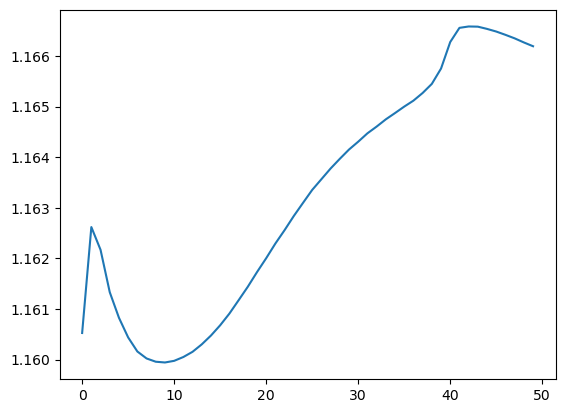

In [198]:
# plt.plot(results2["train_loss"])
plt.plot(results2["test_loss"])

## Train MLP

In [179]:
np.random.seed(seed_number)
torch.manual_seed(seed_number)
torch.cuda.manual_seed_all(seed_number)

model2 = MLP(input_size=X_train_tensor.shape[1], 
             hidden_size=200, output_size=1).to(device)

optimizer= Adan(params=model2.parameters(), 
                lr=0.0001, 
                betas=(0.94, 0.92, 0.95), 
                weight_decay=1e-2)

results1 = {
    "train_loss": [],
    "train_accu": [],
    "test_loss": [],
    "test_accu": []
}

start_time = time.perf_counter()
for epoch in tqdm(range(0, 100)):
  if epoch % num_loss_steps == 0:
    print(f"Epoch: {epoch} \n =====================================================================")

  train_loss, train_accu = train(data_loader = train_dataloader,
                                  model = model2,
                                  loss_fn = loss_fn,
                                  optimizer = optimizer,
                                  calculate_accuracy = calculate_accuracy,
                                  device = device,
                                  loss_steps = num_loss_steps,
                                  seed = seed_number);

  test_loss, test_accu = test(data_loader = test_dataloader,
                              model = model2,
                              loss_fn = loss_fn,
                              calculate_accuracy = calculate_accuracy,
                              device = device,
                              loss_steps = num_loss_steps,
                              seed=seed_number);

  results1["train_loss"].append(train_loss)
  results1["train_accu"].append(train_accu)
  results1["test_loss"].append(test_loss)
  results1["test_accu"].append(test_accu)
  
end_time = time.perf_counter()
total_time = end_time- start_time
print(f"Total Runtime: {total_time / 60: .2f}")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 
Training Loss: 0.96386 | Training R2: -0.0305
Test Loss 0.98024 | Test R2 -0.087310
Epoch: 5 
Training Loss: 0.02333 | Training R2: 0.9720
Test Loss 0.00484 | Test R2 0.994517
Epoch: 10 
Training Loss: 0.01202 | Training R2: 0.9851
Test Loss 0.00131 | Test R2 0.998487
Epoch: 15 
Training Loss: 0.00925 | Training R2: 0.9885
Test Loss 0.00086 | Test R2 0.999055
Epoch: 20 
Training Loss: 0.00739 | Training R2: 0.9907
Test Loss 0.00068 | Test R2 0.999262
Epoch: 25 
Training Loss: 0.00600 | Training R2: 0.9925
Test Loss 0.00059 | Test R2 0.999356
Epoch: 30 
Training Loss: 0.00490 | Training R2: 0.9938
Test Loss 0.00055 | Test R2 0.999405
Epoch: 35 
Training Loss: 0.00402 | Training R2: 0.9949
Test Loss 0.00052 | Test R2 0.999431
Epoch: 40 
Training Loss: 0.00330 | Training R2: 0.9958
Test Loss 0.00050 | Test R2 0.999446
Epoch: 45 
Training Loss: 0.00270 | Training R2: 0.9965
Test Loss 0.00049 | Test R2 0.999452
Epoch: 50 
Training Loss: 0.00220 | Training R2: 0.9972
Test Loss 0.00

## Train Classic KAN

In [ ]:
np.random.seed(seed_number)
torch.manual_seed(seed_number)
torch.cuda.manual_seed_all(seed_number)

model4 = ClassicKAN(in_features = X_train_tensor.shape[1], 
                    out_features=1,
                    hidden_units=100).to(device)

optimizer= Adan(params=model4.parameters(), 
                lr=0.001, 
                betas=(0.94, 0.92, 0.95), 
                weight_decay=1e-2)

results3 = {
    "train_loss": [],
    "train_accu": [],
    "test_loss": [],
    "test_accu": []
}

start_time = time.perf_counter()
for epoch in tqdm(range(0, num_of_epochs)):
  if epoch % num_loss_steps == 0:
    print(f"Epoch: {epoch} \n =====================================================================")

  train_loss, train_accu = train(data_loader = train_dataloader,
                                  model = model4,
                                  loss_fn = loss_fn,
                                  optimizer = optimizer,
                                  calculate_accuracy = calculate_accuracy,
                                  device = device,
                                  loss_steps = num_loss_steps,
                                  seed = seed_number);

  test_loss, test_accu = test(data_loader = test_dataloader,
                              model = model4,
                              loss_fn = loss_fn,
                              calculate_accuracy = calculate_accuracy,
                              device = device,
                              loss_steps = num_loss_steps,
                              seed=seed_number);

  results3["train_loss"].append(train_loss)
  results3["train_accu"].append(train_accu)
  results3["test_loss"].append(test_loss)
  results3["test_accu"].append(test_accu)
  
end_time = time.perf_counter()
total_time = end_time- start_time
print(f"Total Runtime: {total_time / 60: .2f}")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 
Training Loss: 0.51609 | Training R2: 0.4459
Test Loss 0.26923 | Test R2 0.718242
Epoch: 5 
Training Loss: 0.11572 | Training R2: 0.8631
Test Loss 0.08669 | Test R2 0.915119
Epoch: 10 
Training Loss: 0.07582 | Training R2: 0.9091
Test Loss 0.05041 | Test R2 0.951720
Epoch: 15 
Training Loss: 0.06448 | Training R2: 0.9223
Test Loss 0.04174 | Test R2 0.960046
Epoch: 20 
Training Loss: 0.05841 | Training R2: 0.9295
Test Loss 0.04064 | Test R2 0.961129
Epoch: 25 
Training Loss: 0.05234 | Training R2: 0.9367
Test Loss 0.04104 | Test R2 0.960757
Epoch: 30 
Training Loss: 0.04525 | Training R2: 0.9451
Test Loss 0.04228 | Test R2 0.959604
Epoch: 35 
Training Loss: 0.03681 | Training R2: 0.9552
Test Loss 0.04474 | Test R2 0.957159
Epoch: 40 
Training Loss: 0.02729 | Training R2: 0.9665
Test Loss 0.04686 | Test R2 0.955051
Epoch: 45 
Training Loss: 0.01785 | Training R2: 0.9778
Test Loss 0.04964 | Test R2 0.952269
Total Runtime:  0.83
